# Lec 6-2 (FAI) Moving Average Crossover Strategy

금융AI

In [ ]:
# 먼저 필요한 library를 불러오자

import pandas_datareader as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
# 주가 데이터를 불러오자  
# (yahoo finance open API, 공식적으로 없어졌지만, 비공식적으로 서비스는 제공되고 있음)

start = datetime(2019,1,1)
end = datetime(2020,1,1)
#end = datetime.today()

ss = pdr.DataReader('005930.KS','yahoo',start,end) # Samsung Electronics Co., Ltd. (원화 표시 KRW)

In [ ]:
ss.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,39400.0,38550.0,39400.0,38750.0,7847664.0,38750.0
2019-01-03,38550.0,37450.0,38300.0,37600.0,12471493.0,37600.0
2019-01-04,37600.0,36850.0,37450.0,37450.0,14108958.0,37450.0
2019-01-07,38900.0,37800.0,38000.0,38750.0,12748997.0,38750.0
2019-01-08,39200.0,37950.0,38000.0,38100.0,12756554.0,38100.0


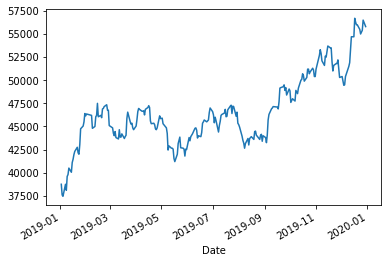

In [ ]:
ss['Close'].plot()

In [ ]:
# Initialize the short and long windows
short_window = 20
long_window = 80

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=ss.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = ss['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = ss['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# 투자전략 : 단기균형 > 장기균형  ==>  Buy 
# 투자전략 : 단기균형 < 장기균형  ==>  Sell 
# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Print `signals`
print(signals)

            signal    short_mavg     long_mavg  positions
Date                                                     
2019-01-02     0.0  38750.000000  38750.000000        NaN
2019-01-03     0.0  38175.000000  38175.000000        0.0
2019-01-04     0.0  37933.333333  37933.333333        0.0
2019-01-07     0.0  38137.500000  38137.500000        0.0
2019-01-08     0.0  38130.000000  38130.000000        0.0
...            ...           ...           ...        ...
2019-12-23     1.0  52652.500000  50163.125000        0.0
2019-12-24     1.0  52812.500000  50300.000000        0.0
2019-12-26     1.0  52972.500000  50440.625000        0.0
2019-12-27     1.0  53232.500000  50604.375000        0.0
2019-12-30     1.0  53507.500000  50751.875000        0.0

[245 rows x 4 columns]


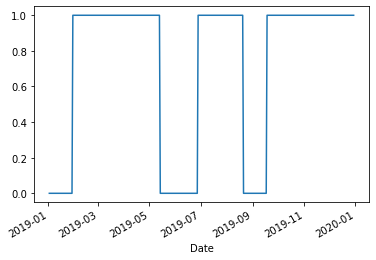

In [ ]:
signals.signal.plot()

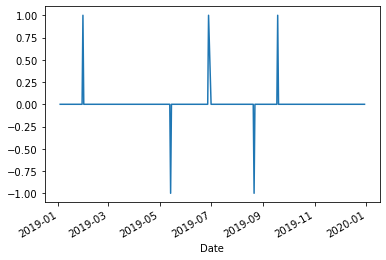

In [ ]:
signals.positions.plot()

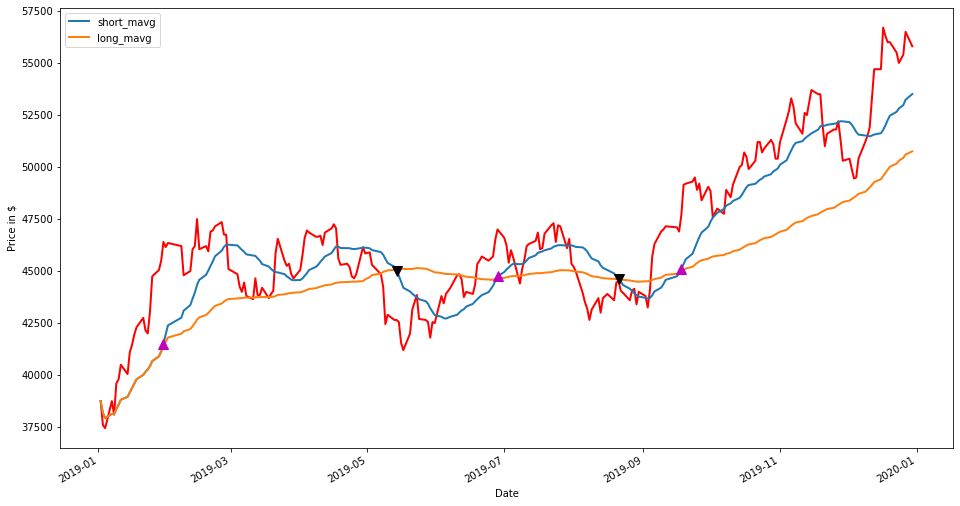

In [ ]:
# Import `pyplot` module as `plt`
#import matplotlib.pyplot as plt

# Initialize the plot figure
fig = plt.figure(figsize=(16,9))

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
ss['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()

## 성과평가

In [ ]:
# Set the initial capital
initial_capital= float(10000000.0) #초기자금 : 천만원

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['SS'] = 100*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(ss['Close'], axis=0)


# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(ss['Close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio 
# (실제 거래에서는 Close로 하는게 맞아요. Adj Close 는 나중에 따로 계산되기 때문)
portfolio['cash'] = initial_capital - (pos_diff.multiply(ss['Close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()*100

# 참고로 종가 및 종가수익률도 첨가해요 (성과평가를 위해서 )
portfolio['Close'] = ss['Close']
portfolio['ret_Close'] = ss['Close'].pct_change()*100

portfolio['ret_position'] = portfolio['ret_Close'].mul(signals['signal'])
portfolio['signal'] =signals['signal']
portfolio['positions'] =signals['positions']

# Print the first lines of `portfolio`
print(portfolio)

                   SS   holdings        cash       total   returns    Close  \
Date                                                                          
2019-01-02        0.0        0.0  10000000.0  10000000.0       NaN  38750.0   
2019-01-03        0.0        0.0  10000000.0  10000000.0  0.000000  37600.0   
2019-01-04        0.0        0.0  10000000.0  10000000.0  0.000000  37450.0   
2019-01-07        0.0        0.0  10000000.0  10000000.0  0.000000  38750.0   
2019-01-08        0.0        0.0  10000000.0  10000000.0  0.000000  38100.0   
...               ...        ...         ...         ...       ...      ...   
2019-12-23  5550000.0  5550000.0   4605000.0  10155000.0 -0.489956  55500.0   
2019-12-24  5500000.0  5500000.0   4605000.0  10105000.0 -0.492368  55000.0   
2019-12-26  5540000.0  5540000.0   4605000.0  10145000.0  0.395844  55400.0   
2019-12-27  5650000.0  5650000.0   4605000.0  10255000.0  1.084278  56500.0   
2019-12-30  5580000.0  5580000.0   4605000.0  101850

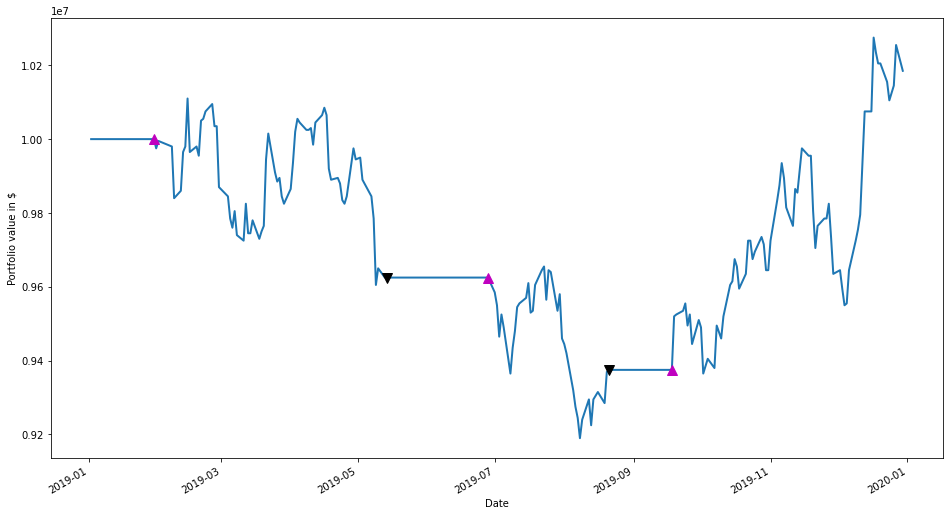

In [ ]:
# Import the `pyplot` module as `plt`
#import matplotlib.pyplot as plt

# Create a figure
fig = plt.figure(figsize=(16,9))

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

### Sharpe Ratio

In [ ]:
# Isolate the returns of your strategy
returns = portfolio['returns']

# annualized Sharpe ratio
sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print(sharpe_ratio)

0.25004018951053325


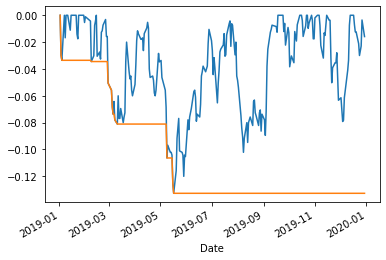

In [ ]:
# Define a trailing 252 trading day window
window = 252

# Calculate the max drawdown in the past window days for each day 
rolling_max = ss['Close'].rolling(window, min_periods=1).max()
daily_drawdown = ss['Close']/rolling_max - 1.0

# Calculate the minimum (negative) daily drawdown
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

# Plot the results
daily_drawdown.plot()
max_daily_drawdown.plot()

# Show the plot
plt.show()

**Compound Annual Growth Rate (CAGR)**

$EV$: the investment's ending value 

$BV$: the investment's beginning value 

$n$: the number of periods

$(EV/BV)^{1/n}−1$

In [ ]:
# Get the number of days in `ss`
days = (ss.index[-1] - ss.index[0]).days

# Calculate the CAGR 
cagr = (((((ss['Close'][-1]) / ss['Close'][0])) ** (365.0/days)) - 1 )*100

# Print the CAGR (%)
print(cagr)

44.435812372883035


In [ ]:
portfolio

,SS,holdings,cash,total,returns,Close,ret_Close,ret_position,signal,positions
Date,,,,,,,,,,
2019-01-02,0.0,0.0,10000000.0,10000000.0,NaN,38750.0,NaN,NaN,0.0,NaN
2019-01-03,0.0,0.0,10000000.0,10000000.0,0.000000,37600.0,-2.967742,-0.000000,0.0,0.0
2019-01-04,0.0,0.0,10000000.0,10000000.0,0.000000,37450.0,-0.398936,-0.000000,0.0,0.0
2019-01-07,0.0,0.0,10000000.0,10000000.0,0.000000,38750.0,3.471295,0.000000,0.0,0.0
2019-01-08,0.0,0.0,10000000.0,10000000.0,0.000000,38100.0,-1.677419,-0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2019-12-23,5550000.0,5550000.0,4605000.0,10155000.0,-0.489956,55500.0,-0.892857,-0.892857,1.0,0.0
2019-12-24,5500000.0,5500000.0,4605000.0,10105000.0,-0.492368,55000.0,-0.900901,-0.900901,1.0,0.0
2019-12-26,5540000.0,5540000.0,4605000.0,10145000.0,0.395844,55400.0,0.727273,0.727273,1.0,0.0


In [ ]:
#벤치마크 전략
ret_ss_hpr = 100*np.log(ss.Close[-1]/ss.Close[0])
ret_ss_hpr

36.46431135879092

In [ ]:
# MA Crossover 전략
ret_strategy = portfolio['ret_position'].sum()
ret_strategy

8.170941754549668

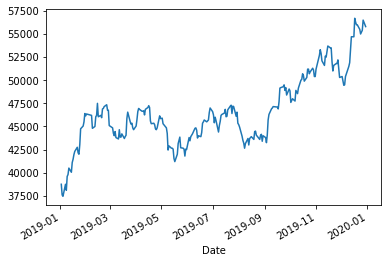

In [ ]:
ss.Close.plot()